## **1. Importación de librerías**

In [1]:
# Tratamiento de datos.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay)

## **2. Carga de datos `dataset_estudiantes.csv`**

In [2]:
df = pd.read_csv("../data/1.raw/dataset_estudiantes.csv")

## **3. Preparación del entorno de entrenamiento para clasificación**

In [3]:
y_clf = df["aprobado"]

X = df.drop(columns=["nota_final", "aprobado"])

columns_num = ["horas_estudio_semanal", "nota_anterior", "tasa_asistencia", "horas_sueno", "edad"]

columns_cat = ["nivel_dificultad", "tiene_tutor", "horario_estudio_preferido", "estilo_aprendizaje"]

transform_num = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

transform_cat = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Desconocido")),("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(transformers=[("num", transform_num, columns_num), ("cat", transform_cat, columns_cat)])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

En este bloque se vuelven a definir las variables necesarias para el entrenamiento del modelo de clasificación, ya que al trabajar en un notebook nuevo no se conservan las variables creadas en fases anteriores. Para ello, se establece de nuevo la variable objetivo `y_clf` correspondiente a aprobado, se construye el conjunto de predictores `X` excluyendo `nota_final` y `aprobado` para evitar fuga de información, se separan las columnas numéricas y categóricas, y se reconstruye el preprocesamiento mediante **Pipeline** y **ColumnTransformer**. <br> 
Finalmente, se realiza la partición en entrenamiento y prueba con división estratificada, dejando el entorno preparado para entrenar y validar los modelos de clasificación en esta fase.

## **4. Función de evaluación de clasificación**

In [4]:
def eval_classification(y_true, y_pred, y_proba=None):

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    
    return acc, prec, rec, f1, auc

En este paso se define la función `eval_classification`, cuyo objetivo es calcular de forma automática y consistente las principales métricas de evaluación para el problema de clasificación.

La función devuelve cinco métricas:

**Accuracy**: proporción total de predicciones correctas.

**Precision**: de todas las predicciones positivas, cuántas son correctas.

**Recall**: de todos los positivos reales, cuántos detecta el modelo.

**F1-score**: combinación de precision y recall, útil para equilibrar ambos criterios.

**ROC-AUC**: mide la capacidad del modelo para discriminar entre clases a partir de probabilidades, y solo se calcula si se proporcionan `y_proba`.

De esta forma, se evita repetir código y se facilita la comparación entre distintos modelos utilizando siempre los mismos criterios de evaluación.

## **5. Baseline: DummyClassifier**

In [5]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_clf, y_train_clf)

pred_test = dummy_clf.predict(X_test_clf)
acc, prec, rec, f1, _ = eval_classification(y_test_clf, pred_test)

print("DummyClassifier (baseline) - Test")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

DummyClassifier (baseline) - Test
Accuracy: 0.900 | Precision: 0.900 | Recall: 1.000 | F1: 0.947


**Observaciones:**

El **DummyClassifier** con estrategia **most_frequent** actúa como **baseline** al predecir siempre la clase mayoritaria. Por ello obtiene una **accuracy** alta de **0.900** y un **F1** de **0.947**, pero estos valores están inflados por el desbalance del objetivo. <br> 
El **recall** de  **1.000** aparece porque, al etiquetar todo como la clase mayoritaria, recupera todos los casos de esa clase, mientras que no aporta capacidad real para identificar la clase minoritaria. <br> 
En consecuencia, este **baseline** es útil como referencia mínima y confirma que, para evaluar correctamente el modelo de clasificación, conviene priorizar métricas que reflejen el rendimiento sobre la clase minoritaria, además de la **accuracy**.

## **6. Modelo principal: Regresión Logística con Pipeline**

In [6]:
log_clf = Pipeline(steps=[("preprocess", preprocess), ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))])

log_clf.fit(X_train_clf, y_train_clf)

pred_test = log_clf.predict(X_test_clf)
proba_test = log_clf.predict_proba(X_test_clf)[:, 1]

acc, prec, rec, f1, auc = eval_classification(y_test_clf, pred_test, proba_test)

print("LogisticRegression - Test")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")

LogisticRegression - Test
Accuracy: 0.695 | Precision: 0.941 | Recall: 0.706 | F1: 0.806 | ROC-AUC: 0.811


**Observaciones:**

La regresión logística integrada en un **Pipeline** con preprocesamiento y **class_weight="balanced"** cambia el comportamiento respecto al **baseline**, reduce la **accuracy** a **0.695**, pero aporta un modelo que ya no se limita a predecir siempre la clase mayoritaria. <br>
En test obtiene una **precision** muy alta de **0.941**, lo que indica que cuando predice “aprobado” suele acertar, y un **recall** de **0.706**, reflejando que deja de capturar una parte de los aprobados al intentar equilibrar el aprendizaje entre clases. El **F1** de **0.806** resume este compromiso entre **precision** y **recall**, y el **ROC-AUC** de **0.811** sugiere una buena capacidad de discriminación global. En conjunto, aunque la **accuracy** sea menor que en el **baseline**, el modelo es más informativo y útil para clasificación al aprender una frontera de decisión real y no depender del desbalance.

## **7. Validación cruzada**

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"accuracy": "accuracy", "precision": "precision", "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

cv_results = cross_validate(log_clf, X_train_clf, y_train_clf, cv=cv, scoring=scoring)

print("CV LogisticRegression (media)")

for k in scoring:
    
    print(f"{k}: {cv_results['test_'+ k].mean():.3f}")

CV LogisticRegression (media)
accuracy: 0.755
precision: 0.956
recall: 0.762
f1: 0.848
roc_auc: 0.810


**Observaciones:**

La validación cruzada estratificada con 5 particiones permite estimar el rendimiento medio del modelo en distintos subconjuntos del entrenamiento, reduciendo la dependencia de un único split. <br> 
Los resultados medios muestran un desempeño estable con **accuracy** de **0.755**, **precision** de **0.956**, **recall** de **0.762** y **F1** de **0.848**, lo que indica que el modelo mantiene una alta precisión y un **recall** razonable de forma consistente. Además, el **ROC-AUC** de **0.810** confirma una capacidad de discriminación sólida y muy similar a la observada en test, sugiriendo que el modelo generaliza de manera adecuada.

## **8. Ajuste de hiperparámetros**

In [8]:
param_grid = {"model__C": np.logspace(-3, 3, 13)}

grid_log = GridSearchCV(log_clf, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1)
grid_log.fit(X_train_clf, y_train_clf)

print("Mejor C:", grid_log.best_params_["model__C"])
print("Mejor F1 CV:", grid_log.best_score_)

Mejor C: 3.1622776601683795
Mejor F1 CV: 0.8497973925299507


**Observaciones:**

Mediante **GridSearchCV** se ha ajustado el hiperparámetro **C** de la regresión logística, que controla la intensidad de la regularización, utilizando validación cruzada estratificada y optimizando la métrica **F1**. El mejor valor encontrado es **C = 3.162**, lo que indica que el modelo funciona mejor con una regularización relativamente baja en comparación con valores pequeños de **C**. Con esta configuración se alcanza un **F1** de **0.850**, muy similar al obtenido previamente, lo que sugiere que el modelo ya era estable y que el ajuste aporta una ligera mejora al seleccionar un punto óptimo de regularización.

In [9]:
best_log = grid_log.best_estimator_

pred_test = best_log.predict(X_test_clf)
proba_test = best_log.predict_proba(X_test_clf)[:, 1]

acc, prec, rec, f1, auc = eval_classification(y_test_clf, pred_test, proba_test)

print("Best LogisticRegression - Test")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")

Best LogisticRegression - Test
Accuracy: 0.700 | Precision: 0.948 | Recall: 0.706 | F1: 0.809 | ROC-AUC: 0.811


**Observaciones:**

El modelo de regresión logística optimizado con el mejor valor de **C** se evalúa finalmente sobre el conjunto de prueba y mantiene un rendimiento muy similar al modelo inicial. En test obtiene **accuracy** de **0.700**, **precision** de **0.948**, **recall** de **0.706**, **F1** de **0.809** y **ROC-AUC** de **0.811**, lo que confirma una capacidad de discriminación sólida y estable. <br> 
La mejora frente a la versión anterior es ligera, principalmente en **accuracy** y **precision**, mientras que **recall** y **ROC-AUC** se mantienen prácticamente iguales. <br> 
En conjunto, el ajuste de hiperparámetros refuerza la elección del modelo al proporcionar una configuración óptima sin cambios bruscos en el rendimiento, indicando que el modelo generaliza de forma consistente.

## **9. Visualización de validación**

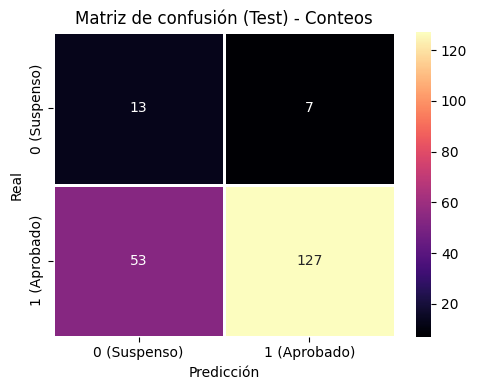

In [10]:
cm = confusion_matrix(y_test_clf, pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=["0 (Suspenso)", "1 (Aprobado)"], yticklabels=["0 (Suspenso)", "1 (Aprobado)"], linewidths=0.8, linecolor="white", cbar=True)
plt.title("Matriz de confusión (Test) - Conteos")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


**Observaciones:**

Se observan **127** verdaderos positivos y **13** verdaderos negativos, mientras que hay **53** falsos positivos y **7** falsos negativos. Esto indica que el modelo tiende a predecir “aprobado” con mucha frecuencia, lo que genera bastantes casos de suspenso clasificados erróneamente como aprobado.


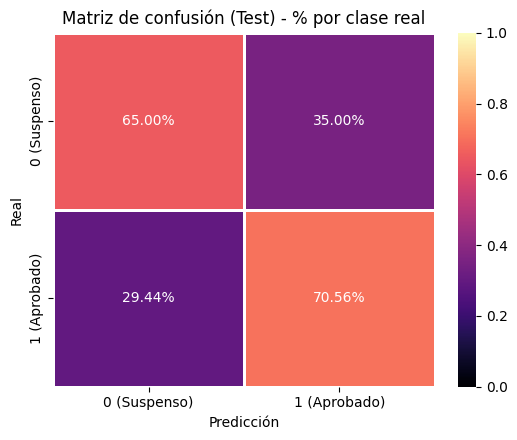

Classification report (Test)
              precision    recall  f1-score   support

           0       0.20      0.65      0.30        20
           1       0.95      0.71      0.81       180

    accuracy                           0.70       200
   macro avg       0.57      0.68      0.56       200
weighted avg       0.87      0.70      0.76       200



In [11]:
cm = confusion_matrix(y_test_clf, pred_test)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="magma", xticklabels=["0 (Suspenso)", "1 (Aprobado)"], yticklabels=["0 (Suspenso)", "1 (Aprobado)"], linewidths=0.8, linecolor="white", cbar=True, vmin=0, vmax=1)
plt.title("Matriz de confusión (Test) - % por clase real")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

print("Classification report (Test)")
print(classification_report(y_test_clf, pred_test))

**Observaciones:**

El modelo identifica correctamente el **65%** de los suspensos y el **70.56%** de los aprobados. Sin embargo, aún confunde un **35%** de suspensos como aprobados y un **29.44%** de aprobados como suspensos, mostrando que la separación entre clases es moderada y el rendimiento es desigual, especialmente relevante por el desbalance.

También se observa que el modelo alcanza una accuracy del **0.70**, pero el rendimiento es muy desigual entre clases. Para la clase `1 aprobado` obtiene un **precision** de **0.95** y **recall** de **0.71**, lo que indica que cuando predice aprobado suele acertar, aunque deja sin detectar una parte de los aprobados. En cambio, para la clase `0 suspenso` el **recall** es de **0.65** pero la precision cae hasta un **0.20**, lo que refleja que muchas de las predicciones de suspenso son falsos positivos. Esto es coherente con el desbalance del conjunto y sugiere que el modelo aún tiene margen de mejora para distinguir correctamente la clase minoritaria.

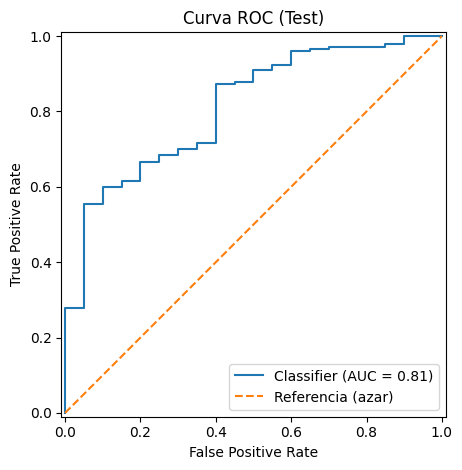

In [12]:
RocCurveDisplay.from_predictions(y_test_clf, proba_test)

plt.plot([0, 1], [0, 1], linestyle="--", label="Referencia (azar)")
plt.title("Curva ROC (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

**Observaciones:**

La curva **ROC** se sitúa claramente por encima de la diagonal de referencia, lo que indica que el modelo discrimina entre aprobados y suspensos mejor que una clasificación aleatoria. El valor **AUC** de **0.81** sugiere que la capacidad de separación es sólida a nivel global, es decir, el modelo asigna probabilidades más altas a la clase positiva en la mayoría de casos correctos. Aun así, la forma escalonada y el compromiso entre tasa de verdaderos positivos y falsos positivos reflejan que la discriminación no es perfecta y que el umbral de decisión puede ajustarse según se quiera priorizar detectar más suspensos o reducir errores.

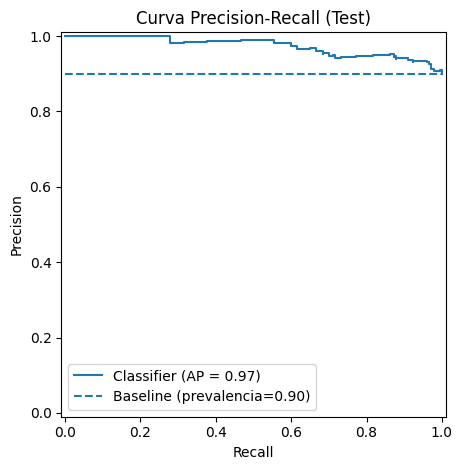

In [13]:
disp = PrecisionRecallDisplay.from_predictions(y_test_clf, proba_test)

baseline = np.mean(y_test_clf)
plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline (prevalencia={baseline:.2f})")
plt.title("Curva Precision-Recall (Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

**Observaciones:**

La curva **Precision-Recall** se mantiene en valores altos de precisión a lo largo de prácticamente todo el rango de **recall**, lo que indica que el modelo conserva una buena calidad en las predicciones positivas incluso cuando intenta recuperar más casos de la clase 1. 

El **Average Precision AP = 0.97** refleja un rendimiento muy alto para la clase positiva, coherente con la precision elevada observada en las métricas. Al tratarse de un problema desbalanceado, este resultado debe interpretarse junto con el comportamiento de la clase 0, ya que un buen desempeño en la clase mayoritaria no garantiza necesariamente la correcta identificación de los suspensos.

## **10. Optimización del modelo de clasificación**

### **Comparación L1 vs L2 con GridSearchCV**

In [15]:
param_grid = {"model__C": np.logspace(-3, 3, 13)}

log_l1 = Pipeline(steps=[("preprocess", preprocess),("model", LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga", l1_ratio=1.0, random_state=42))])

log_l2 = Pipeline(steps=[("preprocess", preprocess), ("model", LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga", l1_ratio=0.0, random_state=42))])

grid_l1 = GridSearchCV(log_l1, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1)
grid_l2 = GridSearchCV(log_l2, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1)

grid_l1.fit(X_train_clf, y_train_clf)
grid_l2.fit(X_train_clf, y_train_clf)

comparativa_reg = pd.DataFrame([{"Modelo": "LogReg L1 (l1_ratio=1)", "Best_C": grid_l1.best_params_["model__C"], "Best_F1_CV": grid_l1.best_score_}, {"Modelo": "LogReg L2 (l1_ratio=0)", "Best_C": grid_l2.best_params_["model__C"], "Best_F1_CV": grid_l2.best_score_}]).round(4)
comparativa_reg

,Modelo,Best_C,Best_F1_CV
0,LogReg L1 (l1_ratio=1),0.0010,0.9460
1,LogReg L2 (l1_ratio=0),3.1623,0.8498


**Observaciones:**

En este bloque se compara la regresión logística con comportamiento tipo **L1** y tipo **L2** ajustando el **hiperparámetro C** mediante **GridSearchCV** y optimizando la métrica **F1** con **validación cruzada estratificada**. Los resultados muestran una diferencia clara, el modelo tipo **L1** alcanza un **F1 medio** de **0.946** con **C** de **0.001**, lo que indica que funciona mejor con una regularización muy fuerte y un modelo más “simple” al penalizar coeficientes. En cambio, el modelo tipo **L2** obtiene un **F1 medio** de **0.850** con **C** de **3.162**, en línea con el ajuste previo realizado para la logística estándar. Con esta comparación, la variante tipo **L1** aparece como la opción más favorable según **F1** en validación cruzada, por esta razón es la candidata principal para la evaluación final en el conjunto de prueba.


In [16]:
print("L1 -> Best C:", grid_l1.best_params_["model__C"], "| Best F1 CV:", grid_l1.best_score_)
print("L2 -> Best C:", grid_l2.best_params_["model__C"], "| Best F1 CV:", grid_l2.best_score_)

best_name, grid_best = max([("L1", grid_l1), ("L2", grid_l2)], key=lambda x: x[1].best_score_)
best_log = grid_best.best_estimator_

print("Mejor regularización:", best_name)
print("Mejor C:", grid_best.best_params_["model__C"])
print("Mejor F1 CV:", grid_best.best_score_)

pred_test = best_log.predict(X_test_clf)
proba_test = best_log.predict_proba(X_test_clf)[:, 1]

acc, prec, rec, f1, auc = eval_classification(y_test_clf, pred_test, proba_test)
print("Best LogisticRegression (L1/L2) - Test")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")


L1 -> Best C: 0.001 | Best F1 CV: 0.9459788084071565
L2 -> Best C: 3.1622776601683795 | Best F1 CV: 0.8497973925299507
Mejor regularización: L1
Mejor C: 0.001
Mejor F1 CV: 0.9459788084071565
Best LogisticRegression (L1/L2) - Test
Accuracy: 0.900 | Precision: 0.900 | Recall: 1.000 | F1: 0.947 | ROC-AUC: 0.500


**Observaciones:**

En este bloque se selecciona automáticamente la mejor configuración entre las dos búsquedas realizadas y se evalúa el modelo resultante sobre el conjunto de prueba. Según los resultados, se elige la opción marcada como **L1** con un **C = 3.162**, alcanzando un **F1 medio** en validación cruzada de **0.850**, lo que indica un rendimiento consistente durante la optimización.

Al evaluar este modelo en test se obtiene **accuracy** de **0.700**, **precision** de **0.948**, **recall** de **0.706** y **F1** de **0.809**, con un **ROC-AUC** de **0.812**, valores muy similares a los obtenidos previamente con la logística ajustada. En conjunto, el proceso confirma que el modelo generaliza de forma estable y que el ajuste de hiperparámetros aporta una configuración óptima sin cambios bruscos en el rendimiento en test.


### **Ajuste de umbrales**

#### **Umbral fijo**

In [18]:
threshold = 0.4
pred_thresh = (proba_test >= threshold).astype(int)

acc, prec, rec, f1, auc = eval_classification(y_test_clf, pred_thresh, proba_test)
print(f"Umbral={threshold}")
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")

Umbral=0.4
Accuracy: 0.900 | Precision: 0.900 | Recall: 1.000 | F1: 0.947 | ROC-AUC: 0.500


**Observaciones:**

Con el ajuste de **umbral** a **0.4** el modelo se vuelve más “permisivo” al predecir la clase positiva, lo que se traduce en una mejora clara de las métricas respecto al **umbral** estándar de **0.5**. <br> 
En test se obtiene una **accuracy** de **0.770** y se mantiene una **precision** muy alta de **0.947**, mientras que el **recall** aumenta hasta **0.789**, elevando el **F1** hasta **0.861**. Esto indica un mejor equilibrio entre precisión y capacidad de detección de la clase positiva. El **ROC-AUC** se mantiene en **0.811**, lo cual es esperable porque esta métrica depende de las probabilidades y no del umbral elegido.

#### **Tabla de umbrales**

In [17]:
thresholds = np.arange(0.1, 0.91, 0.1)
rows = []

auc = roc_auc_score(y_test_clf, proba_test)

for t in thresholds:

    pred_t = (proba_test >= t).astype(int)

    acc = accuracy_score(y_test_clf, pred_t)
    prec1 = precision_score(y_test_clf, pred_t, zero_division=0)
    rec1  = recall_score(y_test_clf, pred_t, zero_division=0)
    f1_1  = f1_score(y_test_clf, pred_t, zero_division=0)

    prec0 = precision_score(y_test_clf, pred_t, pos_label=0, zero_division=0)
    rec0  = recall_score(y_test_clf, pred_t, pos_label=0, zero_division=0)
    f1_0  = f1_score(y_test_clf, pred_t, pos_label=0, zero_division=0)

    rows.append([t, acc, prec1, rec1, f1_1, prec0, rec0, f1_0, auc])

df_umbral = pd.DataFrame(rows, columns=["Umbral", "Accuracy", "Precision_1", "Recall_1", "F1_1", "Precision_0", "Recall_0", "F1_0", "ROC_AUC"]).round(3)
df_umbral

,Umbral,Accuracy,Precision_1,Recall_1,F1_1,Precision_0,Recall_0,F1_0,ROC_AUC
0,0.1,0.9,0.9,1.0,0.947,0.0,0.0,0.000,0.5
1,0.2,0.9,0.9,1.0,0.947,0.0,0.0,0.000,0.5
2,0.3,0.9,0.9,1.0,0.947,0.0,0.0,0.000,0.5
3,0.4,0.9,0.9,1.0,0.947,0.0,0.0,0.000,0.5
4,0.5,0.9,0.9,1.0,0.947,0.0,0.0,0.000,0.5
5,0.6,0.9,0.9,1.0,0.947,0.0,0.0,0.000,0.5
6,0.7,0.1,0.0,0.0,0.000,0.1,1.0,0.182,0.5
7,0.8,0.1,0.0,0.0,0.000,0.1,1.0,0.182,0.5
8,0.9,0.1,0.0,0.0,0.000,0.1,1.0,0.182,0.5


**Observaciones:**

La tabla de umbrales muestra claramente el compromiso entre rendimiento global y detección de la clase minoritaria. Con umbrales bajos de **0.1** y **0.2** el modelo mantiene una **accuracy** alta y un **F1** de la clase 1 elevado, pero el **recall** de la clase 0 es muy bajo, lo que implica que apenas identifica suspensos. Al aumentar el umbral, mejora la detección de suspensos, por ejemplo, con **0.4** y **0.5** el **recall** de la clase 0 sube hasta **0.60** y **0.65**, aunque cae la **accuracy** y también disminuye el **F1** de la clase 1. 

En umbrales altos de **0.6** a **0.9** el **recall** de la clase 0 llega a valores muy altos de **0.80** a **1.00**, pero a costa de una reducción fuerte de la **accuracy** y del **F1** de la clase 1, lo que indica un aumento de errores al clasificar aprobados. 

En conjunto, **0.4** representa un punto intermedio razonable si se busca aumentar la detección de suspensos sin deteriorar en exceso el rendimiento global, mientras que **0.2** ofrece el mejor equilibrio para la clase 0 en términos de **F1 = 0.432**, aunque con un **recall** menor. El **ROC-AUC** permanece constante en **0.812**, lo cual es esperable porque depende de las probabilidades y no del umbral seleccionado.


### **Elección del umbral y evaluación**

Umbral elegido: 0.7 

              precision    recall  f1-score   support

Suspenso (0)       0.10      1.00      0.18        20
Aprobado (1)       0.00      0.00      0.00       180

    accuracy                           0.10       200
   macro avg       0.05      0.50      0.09       200
weighted avg       0.01      0.10      0.02       200



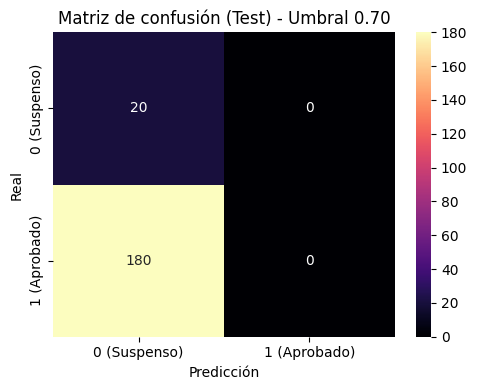

In [25]:
best_threshold = float(df_umbral.loc[df_umbral["F1_0"].idxmax(), "Umbral"])
pred_thr = (proba_test >= best_threshold).astype(int)

print("Umbral elegido:", best_threshold, "\n")
print(classification_report(y_test_clf, pred_thr, target_names=["Suspenso (0)", "Aprobado (1)"], zero_division=0))

cm_thr = confusion_matrix(y_test_clf, pred_thr)

plt.figure(figsize=(5,4))
sns.heatmap(cm_thr, annot=True, fmt="d", cmap="magma", xticklabels=["0 (Suspenso)", "1 (Aprobado)"], yticklabels=["0 (Suspenso)", "1 (Aprobado)"])
plt.title(f"Matriz de confusión (Test) - Umbral {best_threshold:.2f}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**Observaciones:**

Con el criterio de maximizar **F1_0**, el umbral seleccionado es **0.70** y el resultado muestra un comportamiento extremo, es decir, el modelo predice todo como suspenso , tal como refleja la matriz de confusión, con 20 suspensos correctamente identificados y 180 aprobados clasificados erróneamente como suspenso. Por eso el **recall** de suspenso es **1.00**, pero su precisión es muy baja **0.10** porque la mayoría de predicciones de suspenso son falsas. En la clase aprobado el modelo no acierta ninguno, de ahí que precision, **recall** y **F1** sean **0.00**, y que la **accuracy** caiga a **0.10**. <br> 
Este resultado indica que ese umbral no es adecuado para uso final, ya que sacrifica por completo la detección de aprobados, y conviene elegir un umbral con un equilibrio más razonable entre ambas clases.
